In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
df_players = pd.read_csv('player_info.csv')
df_players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3925 entries, 0 to 3924
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   player_id           3925 non-null   int64  
 1   firstName           3925 non-null   object 
 2   lastName            3925 non-null   object 
 3   nationality         3917 non-null   object 
 4   birthCity           3920 non-null   object 
 5   primaryPosition     3925 non-null   object 
 6   birthDate           3925 non-null   object 
 7   birthStateProvince  2802 non-null   object 
 8   height              3922 non-null   object 
 9   height_cm           3922 non-null   float64
 10  weight              3922 non-null   float64
 11  shootsCatches       3908 non-null   object 
dtypes: float64(2), int64(1), object(9)
memory usage: 368.1+ KB


In [3]:
# Find Carey Price 
df_players[df_players.firstName == 'Carey']

,player_id,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,birthStateProvince,height,height_cm,weight,shootsCatches
185,8471679,Carey,Price,CAN,Anahim Lake,G,1987-08-16 01:00:00,BC,"6' 3""",190.5,215.0,L


## Carey Price vs other goalies

In [4]:
df_goalies = pd.read_csv('game_goalie_stats.csv')
df_goalies = df_goalies.dropna()
df_goalies[df_goalies.player_id == 8471679]

,game_id,player_id,team_id,timeOnIce,assists,goals,pim,shots,saves,powerPlaySaves,shortHandedSaves,evenSaves,shortHandedShotsAgainst,evenShotsAgainst,powerPlayShotsAgainst,decision,savePercentage,powerPlaySavePercentage,evenStrengthSavePercentage
12,2016020610,8471679,8,3576,0,0,0,39,35,5,0,30,0,33,6,L,89.743590,83.333333,90.909091
57,2017020482,8471679,8,3709,0,0,0,32,31,5,3,23,3,24,5,W,96.875000,100.000000,95.833333
71,2016020264,8471679,8,3595,0,0,0,32,31,6,2,23,2,23,7,W,96.875000,85.714286,100.000000
200,2016020759,8471679,8,3514,0,0,0,23,21,5,0,16,0,17,6,L,91.304348,83.333333,94.117647
286,2016020143,8471679,8,3600,0,0,0,42,42,4,1,37,1,37,4,W,100.000000,100.000000,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55821,2018021155,8471679,8,3600,0,0,0,27,23,4,0,19,0,22,5,W,85.185185,80.000000,86.363636
55840,2018021166,8471679,8,3794,0,0,0,40,38,1,0,37,0,39,1,L,95.000000,100.000000,94.871795
55850,2018021166,8471679,8,3794,0,0,0,40,38,1,0,37,0,39,1,L,95.000000,100.000000,94.871795
55900,2018021180,8471679,8,3600,0,0,0,34,33,9,3,21,3,21,10,W,97.058824,90.000000,100.000000


In [5]:
# His save percentage when both teams are at even strength (no one in the penalty box)
df_goalies[df_goalies.player_id == 8471679]['evenStrengthSavePercentage'].mean()

91.9986990972293

## Carey still does better than the rest of the league.

In [6]:
# the entire league average save percentage
df_goalies['evenStrengthSavePercentage'].mean()

91.61411967960098

### Create DataFrame of distinct goalies and their mean save percentages

In [7]:
# Grab all goalie averages, convert to DataFrame
df_goalie_averages = df_goalies.groupby(['player_id'])['evenStrengthSavePercentage'].mean()
df_goalie_averages = df_goalie_averages.to_frame()
df_goalie_averages.rename(columns = {'evenStrengthSavePercentage': 'SavePercentage'}, inplace=True)
df_goalie_averages.reset_index(inplace=True)

In [8]:
df_goalie_averages[df_goalie_averages.player_id == 8471679]

,player_id,SavePercentage
179,8471679,91.998699


## Plot proportions and counts of goalies based on their save percentages

C:\Users\phill\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


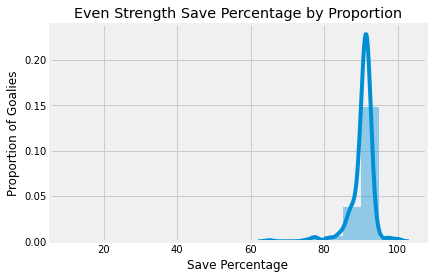

In [9]:
# Plot the proportions of goalie save percentages 

bins = np.arange(10, df_goalie_averages['SavePercentage'].max()+5, 5)
sb.distplot(df_goalie_averages['SavePercentage'], bins=bins)
plt.xlabel('Save Percentage')
plt.ylabel('Proportion of Goalies')
plt.title('Even Strength Save Percentage by Proportion')
plt.show()

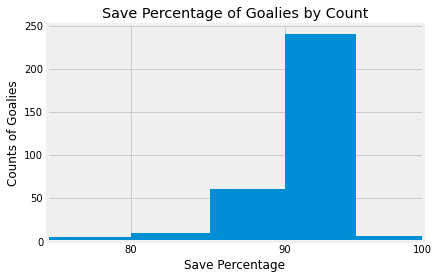

In [10]:
# Plot the counts of goalies by their average save percentage
ticks = [50, 60, 70, 80, 90, 100]
labels = ['{}'.format(v) for v in ticks]
plt.hist(data = df_goalie_averages, x = 'SavePercentage', bins=bins)
plt.xscale('log')
plt.xticks(ticks, labels)
plt.xlim((75,100))
plt.xlabel('Save Percentage')
plt.ylabel('Counts of Goalies')
plt.title('Save Percentage of Goalies by Count')
plt.show()

### Covert game_id to str, substring out last two numbers, then convert to date and add as extra column
The data in each of these files has a unique game_id. It almost looks like it could be broken down into a date and the game number in that season. Using this assumption I want to break it out into a new date field to get so I can visualize over time how many saves Carey has in his career.

In [11]:
df_goalies['date'] = df_goalies['game_id'].apply(str)
df_goalies

,game_id,player_id,team_id,timeOnIce,assists,goals,pim,shots,saves,powerPlaySaves,shortHandedSaves,evenSaves,shortHandedShotsAgainst,evenShotsAgainst,powerPlayShotsAgainst,decision,savePercentage,powerPlaySavePercentage,evenStrengthSavePercentage,date
1,2016020045,8473461,4,2011,0,0,0,11,9,1,0,8,0,10,1,L,81.818182,100.0,80.000000,2016020045
2,2016020045,8470645,16,3598,0,0,0,27,23,2,0,21,0,23,4,W,85.185185,50.0,91.304348,2016020045
3,2017020812,8468011,24,3696,0,0,0,33,30,1,2,27,3,28,2,W,90.909091,50.0,96.428571,2017020812
4,2017020812,8475215,7,3539,0,0,0,33,29,4,1,24,1,27,5,L,87.878788,80.0,88.888889,2017020812
5,2015020314,8473575,21,3600,0,0,0,21,20,3,1,16,1,17,3,W,95.238095,100.0,94.117647,2015020314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56649,2018030416,8476412,19,3487,0,0,0,31,27,3,1,23,1,26,4,L,87.096774,75.0,88.461538,2018030416
56650,2018030416,8471695,6,3600,0,0,0,29,28,12,1,15,1,16,12,W,96.551724,100.0,93.750000,2018030416
56651,2018030416,8476412,19,3487,0,0,0,31,27,3,1,23,1,26,4,L,87.096774,75.0,88.461538,2018030416
56652,2018030417,8476412,19,3600,0,0,0,33,32,3,0,29,0,30,3,W,96.969697,100.0,96.666667,2018030417


In [12]:
df_goalies['date'] = df_goalies['date'].str.slice(0, 8)
df_goalies

,game_id,player_id,team_id,timeOnIce,assists,goals,pim,shots,saves,powerPlaySaves,shortHandedSaves,evenSaves,shortHandedShotsAgainst,evenShotsAgainst,powerPlayShotsAgainst,decision,savePercentage,powerPlaySavePercentage,evenStrengthSavePercentage,date
1,2016020045,8473461,4,2011,0,0,0,11,9,1,0,8,0,10,1,L,81.818182,100.0,80.000000,20160200
2,2016020045,8470645,16,3598,0,0,0,27,23,2,0,21,0,23,4,W,85.185185,50.0,91.304348,20160200
3,2017020812,8468011,24,3696,0,0,0,33,30,1,2,27,3,28,2,W,90.909091,50.0,96.428571,20170208
4,2017020812,8475215,7,3539,0,0,0,33,29,4,1,24,1,27,5,L,87.878788,80.0,88.888889,20170208
5,2015020314,8473575,21,3600,0,0,0,21,20,3,1,16,1,17,3,W,95.238095,100.0,94.117647,20150203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56649,2018030416,8476412,19,3487,0,0,0,31,27,3,1,23,1,26,4,L,87.096774,75.0,88.461538,20180304
56650,2018030416,8471695,6,3600,0,0,0,29,28,12,1,15,1,16,12,W,96.551724,100.0,93.750000,20180304
56651,2018030416,8476412,19,3487,0,0,0,31,27,3,1,23,1,26,4,L,87.096774,75.0,88.461538,20180304
56652,2018030417,8476412,19,3600,0,0,0,33,32,3,0,29,0,30,3,W,96.969697,100.0,96.666667,20180304


In [13]:
## if date ends in 00, then remove, assumption is there are preseason games included in these dataframes that we want to remove
df_goalies = df_goalies[~df_goalies['date'].str.endswith('00')]

df_goalies['date'] = pd.to_datetime(df_goalies['date'], format='%Y-%m-%d')
df_goalies.drop_duplicates(inplace=True)
df_goalies.head()

<ipython-input-13-30bb4ee47ec7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_goalies['date'] = pd.to_datetime(df_goalies['date'], format='%Y-%m-%d')
<ipython-input-13-30bb4ee47ec7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_goalies.drop_duplicates(inplace=True)


,game_id,player_id,team_id,timeOnIce,assists,goals,pim,shots,saves,powerPlaySaves,shortHandedSaves,evenSaves,shortHandedShotsAgainst,evenShotsAgainst,powerPlayShotsAgainst,decision,savePercentage,powerPlaySavePercentage,evenStrengthSavePercentage,date
3,2017020812,8468011,24,3696,0,0,0,33,30,1,2,27,3,28,2,W,90.909091,50.0,96.428571,2017-02-08
4,2017020812,8475215,7,3539,0,0,0,33,29,4,1,24,1,27,5,L,87.878788,80.0,88.888889,2017-02-08
5,2015020314,8473575,21,3600,0,0,0,21,20,3,1,16,1,17,3,W,95.238095,100.0,94.117647,2015-02-03
6,2015020314,8474636,52,3520,0,0,0,28,25,4,0,21,0,23,5,L,89.285714,80.0,91.304348,2015-02-03
7,2015020849,8471715,52,3475,0,0,0,29,27,8,1,18,1,18,10,L,93.103448,80.0,100.000000,2015-02-08


In [14]:
df_goalies[df_goalies.player_id == 8471679]['date']

12      2016-02-06
57      2017-02-04
71      2016-02-02
200     2016-02-07
286     2016-02-01
           ...    
55666   2018-02-11
55728   2018-02-11
55793   2018-02-11
55840   2018-02-11
55900   2018-02-11
Name: date, Length: 612, dtype: datetime64[ns]

In [15]:
price_saves = df_goalies[df_goalies.player_id == 8471679]['evenStrengthSavePercentage']
price_saves

price_dates = df_goalies[df_goalies.player_id == 8471679]['date']
price_dates.head()


12    2016-02-06
57    2017-02-04
71    2016-02-02
200   2016-02-07
286   2016-02-01
Name: date, dtype: datetime64[ns]

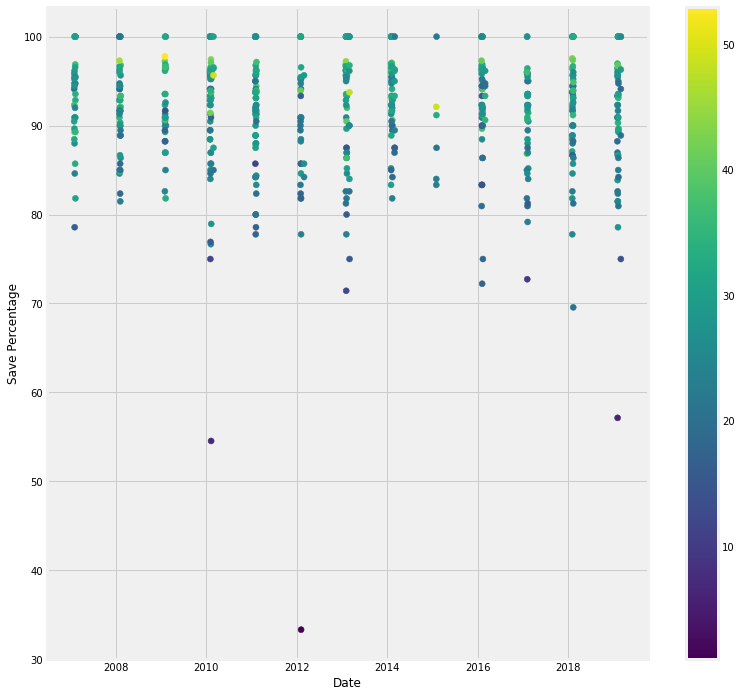

In [16]:
# Plot the dates and amounts of saves over Carey's career
fig = plt.figure(figsize=[12, 12])
colors = df_goalies[df_goalies.player_id == 8471679]['saves']
plt.scatter(price_dates, price_saves, c=colors, cmap='viridis')
plt.ylabel('Save Percentage')
plt.xlabel('Date')
plt.colorbar()
plt.show()

## Grab all goalies higher than the average of averages and compare against Carey Price
Now I want to figure out just how good Carey Price is compared to everyone. We'll start by getting the average of all goalies and then comparing that save percentage to Carey Price's own.

In [17]:
df_goalie_averages.isnull().sum()

player_id         0
SavePercentage    0
dtype: int64

In [18]:
df_goalie_averages['SavePercentage'].mean() # Fix this later, revert back to original

90.45806649593396

In [19]:
best_goalies = df_goalie_averages[ df_goalie_averages >= df_goalie_averages['SavePercentage'].mean()]

In [20]:
best_goalies = best_goalies.dropna()

In [21]:
best_goalies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224 entries, 0 to 322
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   player_id       224 non-null    int64  
 1   SavePercentage  224 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 5.2 KB


In [22]:
best_goalies.describe()

,player_id,SavePercentage
count,2.240000e+02,224.000000
mean,8.469357e+06,91.851096
std,7.887612e+03,1.318333
min,8.445275e+06,90.494998
25%,8.464928e+06,91.061906
50%,8.471033e+06,91.620595
75%,8.475661e+06,92.169027
max,8.480925e+06,100.000000


In [23]:
best_goalies.loc[best_goalies['SavePercentage']==100]

,player_id,SavePercentage
221,8475130,100.0
254,8476330,100.0


In [24]:
best_goalies.loc[best_goalies['player_id']==8471679]

,player_id,SavePercentage
179,8471679,91.998699


## Visualize Carey Price against 4 of the greatest goalies to play the game in the last 15 years.
I want to see how Andrei Vasilevskiy, Tuukka Rask, Semyon Varlamov, and Henrik Lundqvist all compare to Carey Price as goalies.

In [25]:
# Plot 5 of the best goalies in the NHL to rank their average save percentage
great_goalies = [8471679, 8468685, 8473575, 8471695, 8476883]

top_five = pd.DataFrame()
for goalie in great_goalies:
  top_five = top_five.append(best_goalies.loc[best_goalies['player_id']==goalie])

top_five = pd.merge(top_five, df_players, on='player_id')
top_five['fullName'] = top_five['firstName'] + ' ' + top_five['lastName']
top_five = top_five[['player_id', 'SavePercentage', 'fullName']]
top_five.sort_values('SavePercentage', inplace=True)
top_five

,player_id,SavePercentage,fullName
2,8473575,91.828677,Semyon Varlamov
0,8471679,91.998699,Carey Price
4,8476883,92.144824,Andrei Vasilevskiy
1,8468685,92.424957,Henrik Lundqvist
3,8471695,92.869342,Tuukka Rask


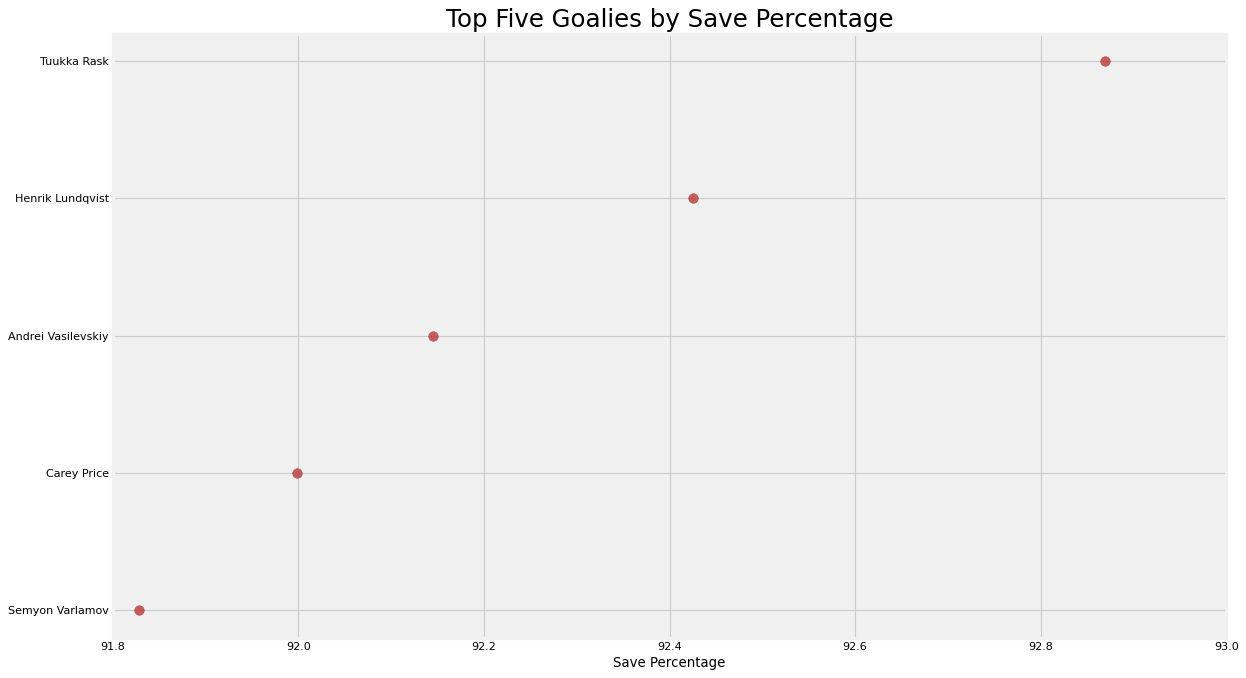

In [26]:
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)
ax.hlines(y=top_five.player_id, xmin=11, xmax=26, color='gray', alpha=0.7, linewidth=1, linestyles='dashdot')
ax.scatter(y=top_five.fullName, x=top_five.SavePercentage, s=75, color='firebrick', alpha=0.7)

# Title, Label, Ticks and Ylim
ax.set_title('Top Five Goalies by Save Percentage', fontdict={'size':22})
ax.set_xlabel('Save Percentage')
ax.set_yticks(top_five.fullName)
ax.set_yticklabels(top_five.fullName, fontdict={'horizontalalignment': 'right'})
ax.set_xlim(91.8, 93)
plt.show()

## Results?
Overall, Carey comes in 4th place against these great goalies. Nearly 92 shots out of 100 is nothing to scoff out, but for players like Henrik Lundqvist and Tuukka Rask, they are both able to make that extraordinary effort to save more. I would want to dig deeper into this, like how a team's defense plays into protecting their goalie, or limiting the options forwards can have to set up and make shots. Maybe we would find that Carey's team (Montreal Canadiens) doesn't have as good a defense over this period of time compared to Henrik's (Rangers) and Tuukka's (Bruins).

## Alexander Ovechkin Goals
Alexander Ovechkin is chasing after history. He wants to surpass Wayne Gretzsky's all-time goal record. And he just might do it. Let's see how many goals he has amassed in his career so far.

In [27]:
# Find Alexander Ovechkin
df_players[df_players.lastName == 'Ovechkin']

,player_id,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,birthStateProvince,height,height_cm,weight,shootsCatches
186,8471214,Alex,Ovechkin,RUS,Moscow,LW,1985-09-17 01:00:00,NaN,"6' 3""",190.5,235.0,R


In [28]:
# Clean the data of duplicates and sum Ovi's goal total
df_goals = pd.read_csv('game_skater_stats.csv')
df_goals.drop_duplicates(inplace=True)
df_goals[df_goals.player_id == 8471214].goals.sum()

755

## What's wrong with the data?
So I've removed any duplicates, and this dataset only goes through the 2019-2020 season, but a quick check on ESPN.com says that Ovechkin had about anywhere from about 658 to 706 goals about that time if you subtract the last two seasons from his total. I need as close of an accurate goal count I can get from the data before building a neural network.

In [29]:
df_goals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 853404 entries, 0 to 945793
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   game_id               853404 non-null  int64  
 1   player_id             853404 non-null  int64  
 2   team_id               853404 non-null  int64  
 3   timeOnIce             853404 non-null  int64  
 4   assists               853404 non-null  int64  
 5   goals                 853404 non-null  int64  
 6   shots                 853404 non-null  int64  
 7   hits                  455297 non-null  float64
 8   powerPlayGoals        853404 non-null  int64  
 9   powerPlayAssists      853404 non-null  int64  
 10  penaltyMinutes        853404 non-null  int64  
 11  faceOffWins           853404 non-null  int64  
 12  faceoffTaken          853404 non-null  int64  
 13  takeaways             455297 non-null  float64
 14  giveaways             455297 non-null  float64
 15  

### Fix dates, then create running total after each game and add additional column for neural network.
Again, I'm using the assumption that the game_id is a combination of a date and game number and I want to do what I did with it for Carey Price so I can create a running total of his career goals after each game.

In [30]:
df_goals['gameID'] = df_goals['game_id'].apply(str)
df_goals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 853404 entries, 0 to 945793
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   game_id               853404 non-null  int64  
 1   player_id             853404 non-null  int64  
 2   team_id               853404 non-null  int64  
 3   timeOnIce             853404 non-null  int64  
 4   assists               853404 non-null  int64  
 5   goals                 853404 non-null  int64  
 6   shots                 853404 non-null  int64  
 7   hits                  455297 non-null  float64
 8   powerPlayGoals        853404 non-null  int64  
 9   powerPlayAssists      853404 non-null  int64  
 10  penaltyMinutes        853404 non-null  int64  
 11  faceOffWins           853404 non-null  int64  
 12  faceoffTaken          853404 non-null  int64  
 13  takeaways             455297 non-null  float64
 14  giveaways             455297 non-null  float64
 15  

In [31]:
df_goals = df_goals[~df_goals['gameID'].str.endswith('00')]
df_goals.shape

(845449, 23)

In [32]:
df_goals[df_goals.player_id == 8471214].goals.sum()

752

In [33]:
df_goals['date'] = df_goals['gameID'].str.slice(0, 8)
df_goals.head()

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,...,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,gameID,date
0,2016020045,8468513,4,955,1,0,0,2.0,0,0,...,1.0,0,0,1.0,1,858,97,0,2016020045,20160200
1,2016020045,8476906,4,1396,1,0,4,2.0,0,0,...,2.0,0,0,2.0,0,1177,0,219,2016020045,20160200
2,2016020045,8474668,4,915,0,0,1,1.0,0,0,...,0.0,0,0,0.0,-1,805,0,110,2016020045,20160200
3,2016020045,8473512,4,1367,3,0,0,0.0,0,2,...,0.0,0,0,0.0,-1,1083,19,265,2016020045,20160200
4,2016020045,8471762,4,676,0,0,3,2.0,0,0,...,1.0,0,0,0.0,-1,613,63,0,2016020045,20160200


In [34]:
df_goals = df_goals[~df_goals['date'].str.endswith('00')]
df_goals.head()

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,...,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,gameID,date
36,2017020812,8470616,24,1238,0,0,2,3.0,0,0,...,0.0,0,0,0.0,-1,1047,8,183,2017020812,20170208
37,2017020812,8476806,24,480,0,0,1,0.0,0,0,...,1.0,0,0,0.0,0,469,11,0,2017020812,20170208
38,2017020812,8475764,24,1594,1,0,3,0.0,0,1,...,0.0,0,0,0.0,0,1380,58,156,2017020812,20170208
39,2017020812,8470612,24,1215,1,0,4,1.0,0,1,...,2.0,0,0,1.0,0,1057,48,110,2017020812,20170208
40,2017020812,8477986,24,1108,1,0,1,2.0,0,0,...,0.0,0,0,0.0,2,914,11,183,2017020812,20170208


In [35]:
ovi_goals = df_goals[df_goals.player_id == 8471214]
ovi_goals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1148 entries, 184 to 942826
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   game_id               1148 non-null   int64  
 1   player_id             1148 non-null   int64  
 2   team_id               1148 non-null   int64  
 3   timeOnIce             1148 non-null   int64  
 4   assists               1148 non-null   int64  
 5   goals                 1148 non-null   int64  
 6   shots                 1148 non-null   int64  
 7   hits                  790 non-null    float64
 8   powerPlayGoals        1148 non-null   int64  
 9   powerPlayAssists      1148 non-null   int64  
 10  penaltyMinutes        1148 non-null   int64  
 11  faceOffWins           1148 non-null   int64  
 12  faceoffTaken          1148 non-null   int64  
 13  takeaways             790 non-null    float64
 14  giveaways             790 non-null    float64
 15  shortHandedGoals 

In [36]:
ovi_goals['goals'].sum()

681

## Start putting together neural net training set

In [37]:
df_games = pd.read_csv('game.csv')

In [38]:
# Merge Ovechkin data with the games data and clean to remove duplicates
result = pd.merge(ovi_goals, df_games, on='game_id')
result.drop_duplicates(inplace=True)
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1148 entries, 0 to 1290
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   game_id                 1148 non-null   int64  
 1   player_id               1148 non-null   int64  
 2   team_id                 1148 non-null   int64  
 3   timeOnIce               1148 non-null   int64  
 4   assists                 1148 non-null   int64  
 5   goals                   1148 non-null   int64  
 6   shots                   1148 non-null   int64  
 7   hits                    790 non-null    float64
 8   powerPlayGoals          1148 non-null   int64  
 9   powerPlayAssists        1148 non-null   int64  
 10  penaltyMinutes          1148 non-null   int64  
 11  faceOffWins             1148 non-null   int64  
 12  faceoffTaken            1148 non-null   int64  
 13  takeaways               790 non-null    float64
 14  giveaways               790 non-null    

## Where I discovered I was wrong...
In the cell below, I took a glance at what the game_id looked like compared to the date_time_GMT field from the game.csv. It turns out, if you break out what would look like the date from game_id, it does not match the date_time_GMT field. So what is this game_id? Is it just a random number? It doesn't look like it to me, but it won't work for what I have in mind.

In [39]:
result[['game_id', 'date_time_GMT']]

,game_id,date_time_GMT
0,2016020610,2017-01-10T00:30:00Z
1,2017020706,2018-01-20T00:30:00Z
2,2017020285,2017-11-17T02:00:00Z
3,2017020301,2017-11-19T00:30:00Z
4,2015021029,2016-03-13T03:30:00Z
...,...,...
1282,2018030133,2019-04-15T23:00:00Z
1284,2018030134,2019-04-18T23:00:00Z
1286,2018030135,2019-04-21T00:00:00Z
1288,2018030136,2019-04-22T23:00:00Z


In [40]:
# Sort the result dataset by game dates
result.sort_values(by=['date_time_GMT'], inplace=True)
result.head()

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,...,home_team_id,away_goals,home_goals,outcome,home_rink_side_start,venue,venue_link,venue_time_zone_id,venue_time_zone_offset,venue_time_zone_tz
886,2005020101,8471214,15,1200,0,2,10,NaN,0,0,...,13,2,3,home win REG,right,BankAtlantic Center,/api/v1/venues/null,America/New_York,-4,EDT
904,2005020115,8471214,15,1075,0,0,2,NaN,0,0,...,15,4,0,away win REG,right,Verizon Center,/api/v1/venues/null,America/New_York,-4,EDT
907,2005020138,8471214,15,1056,1,0,5,NaN,0,1,...,7,3,2,away win REG,left,HSBC Arena,/api/v1/venues/null,America/New_York,-4,EDT
902,2005020155,8471214,15,1324,0,2,4,NaN,0,0,...,14,2,4,home win REG,left,St. Pete Times Forum,/api/v1/venues/null,America/New_York,-4,EDT
866,2005020192,8471214,15,1399,0,0,7,NaN,0,0,...,4,1,8,home win REG,right,Wachovia Center,/api/v1/venues/null,America/New_York,-4,EDT


In [41]:
# Create a column over the data that adds the cumulative sum of Ovechkin's goals by each game
result['careerGoals'] = result.goals.cumsum()
result

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,...,away_goals,home_goals,outcome,home_rink_side_start,venue,venue_link,venue_time_zone_id,venue_time_zone_offset,venue_time_zone_tz,careerGoals
886,2005020101,8471214,15,1200,0,2,10,NaN,0,0,...,2,3,home win REG,right,BankAtlantic Center,/api/v1/venues/null,America/New_York,-4,EDT,2
904,2005020115,8471214,15,1075,0,0,2,NaN,0,0,...,4,0,away win REG,right,Verizon Center,/api/v1/venues/null,America/New_York,-4,EDT,2
907,2005020138,8471214,15,1056,1,0,5,NaN,0,1,...,3,2,away win REG,left,HSBC Arena,/api/v1/venues/null,America/New_York,-4,EDT,2
902,2005020155,8471214,15,1324,0,2,4,NaN,0,0,...,2,4,home win REG,left,St. Pete Times Forum,/api/v1/venues/null,America/New_York,-4,EDT,4
866,2005020192,8471214,15,1399,0,0,7,NaN,0,0,...,1,8,home win REG,right,Wachovia Center,/api/v1/venues/null,America/New_York,-4,EDT,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,2019030131,8471214,15,1479,0,0,6,6.0,0,0,...,4,2,away win REG,right,Scotiabank Arena,/api/v1/venues/null,America/New_York,-5,EST,677
1126,2019030132,8471214,15,1333,0,2,6,4.0,0,0,...,5,2,away win REG,right,Scotiabank Arena,/api/v1/venues/null,America/New_York,-5,EST,679
1128,2019030133,8471214,15,1301,1,0,1,7.0,0,1,...,1,2,home win OT,left,Scotiabank Arena,/api/v1/venues/null,America/New_York,-5,EST,679
1130,2019030134,8471214,15,1111,0,2,4,3.0,1,0,...,3,2,away win REG,left,Scotiabank Arena,/api/v1/venues/null,America/New_York,-5,EST,681


In [42]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1148 entries, 886 to 1132
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   game_id                 1148 non-null   int64  
 1   player_id               1148 non-null   int64  
 2   team_id                 1148 non-null   int64  
 3   timeOnIce               1148 non-null   int64  
 4   assists                 1148 non-null   int64  
 5   goals                   1148 non-null   int64  
 6   shots                   1148 non-null   int64  
 7   hits                    790 non-null    float64
 8   powerPlayGoals          1148 non-null   int64  
 9   powerPlayAssists        1148 non-null   int64  
 10  penaltyMinutes          1148 non-null   int64  
 11  faceOffWins             1148 non-null   int64  
 12  faceoffTaken            1148 non-null   int64  
 13  takeaways               790 non-null    float64
 14  giveaways               790 non-null  

In [43]:
# Create a dataset with the relevant columns for a neural net, then clean up the dates, and set them as indexes
oviData = pd.DataFrame(result, columns=['game_id', 'player_id', 'goals', 'date_time_GMT', 'careerGoals'])
oviData['date'] = oviData['date_time_GMT'].str.slice(0, 10)
oviData['date'] = pd.to_datetime(oviData['date'], format='%Y-%m-%d')
oviData = oviData.set_index('date')
oviData.shape

(1148, 5)

## My training and test set
I put together the training/test set in the cell below for my neural net. I'm using the date as my index, with a few important fields I wanted to include in case I run into something I might need later. I've included a careerGoals field at the end that provides the running total of all of Ovechkin's goals to feed my neural network so it can make predictions about how many goals he will get.

In [44]:
oviData.head()

,game_id,player_id,goals,date_time_GMT,careerGoals
date,,,,,
2005-10-20,2005020101,8471214,2,2005-10-20T23:00:00Z,2
2005-10-22,2005020115,8471214,0,2005-10-22T23:00:00Z,2
2005-10-26,2005020138,8471214,0,2005-10-26T23:30:00Z,2
2005-10-28,2005020155,8471214,2,2005-10-28T23:30:00Z,4
2005-11-04,2005020192,8471214,0,2005-11-04T00:00:00Z,4


# Build Neural Net to predict future goals for Alexander Ovechkin
Here I began the process of normalizing my data, splitting it out into a test and training set, and finally training my neural network to make predictions on how many goals Alexander Ovechkin would get in his career. I used a YouTube video from the Computer Science channel about a similar neural network trained to make stock price predictions over time and repurposed it for this project. I also included some hyperparameters to help with precision and accuracy of the neural network. It was all a little over my head, but I followed along as best I could and tried different things to get the neural network to work as best I could.

In [45]:
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras import regularizers

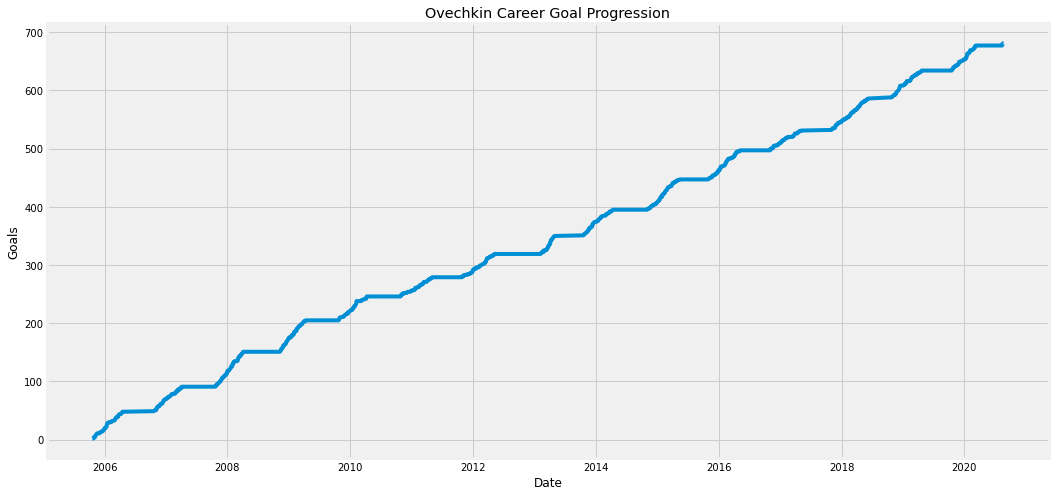

In [46]:
# Show the career goal progression of Alexander Ovechkin
plt.figure(figsize=(16,8))
plt.title('Ovechkin Career Goal Progression')
plt.plot(oviData['careerGoals'])
plt.xlabel('Date')
plt.ylabel('Goals')
plt.show()

## Observations of Career Goal Progression
So we can see the steady incline of Ovechkin's goal progressions over time. Every game is used and each time he adds goals to his careerGoals field, the progression goes up. But what about the flat lines? Well every hockey season has to come to an end at some point and these represent the offseason where no games are played and no goals are counted. We will want to make sure that the neural net can account for this period of time.

In [47]:
# Create a Series of of the cumulative goal counts and get the training data length
data = oviData.filter(['careerGoals'])

dataset = data.values

training_data_len = math.ceil(len(dataset) * .8)

training_data_len

919

In [48]:
# scale the goal counts using MinMaxScaler to reduce them all between 0 and 1
# fit the data to be scaled.
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.99705449],
       [1.        ],
       [1.        ]])

In [49]:
#get the training data from our scaled dataset and append 60 (totals after each game) records to x_train and the 61 to y_train, 
#60 is arbitrary
train_data = scaled_data[0:training_data_len, :]

x_train = [] 
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  if i<= 60:
    print(x_train)
    print(y_train)
    print()

[array([0.        , 0.        , 0.        , 0.00294551, 0.00294551,
       0.00589102, 0.00883652, 0.01030928, 0.01030928, 0.01178203,
       0.01325479, 0.01325479, 0.01325479, 0.01325479, 0.01325479,
       0.01325479, 0.01325479, 0.01472754, 0.01620029, 0.01767305,
       0.01767305, 0.01767305, 0.01767305, 0.0191458 , 0.02061856,
       0.02209131, 0.02356406, 0.02503682, 0.02650957, 0.02650957,
       0.02798233, 0.02798233, 0.02945508, 0.03092784, 0.0353461 ,
       0.03829161, 0.03976436, 0.03976436, 0.03976436, 0.04123711,
       0.04123711, 0.04123711, 0.04123711, 0.04123711, 0.04123711,
       0.04270987, 0.04418262, 0.04565538, 0.04712813, 0.04860088,
       0.05154639, 0.05301915, 0.05301915, 0.05301915, 0.0544919 ,
       0.0544919 , 0.0544919 , 0.05596465, 0.05596465, 0.05891016])]
[0.06038291605301914]



In [50]:
# convert x and y train to array objects
x_train, y_train = np.array(x_train), np.array(y_train)

In [51]:
# Reshape x_train to be 3 dimensions (# of rows, # of columns, # of features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(859, 60, 1)

In [52]:
# Build our RNN model
model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape=(x_train.shape[1], 1), bias_regularizer=regularizers.l2(1e-4)))
model.add(LSTM(60, return_sequences=False))
model.add(Dense(30))
model.add(Dense(1))

In [53]:
#Compile with adam (SGD) optimizer and loss function based off mean squared error (how we minimize errors in our model)
model.compile(optimizer='adam', loss='mean_squared_error')

In [54]:
# Fit the training data on our model, 1 batch of all our data, 3 cycles (epochs) for training
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
859/859 [==============================] - 7s 9ms/step - loss: 0.0056
Epoch 2/3
859/859 [==============================] - 7s 9ms/step - loss: 0.0022
Epoch 3/3
859/859 [==============================] - 7s 9ms/step - loss: 0.0010


In [55]:
# Create our testing training set on the last 60 records
test_data = scaled_data[training_data_len - 60: , :]

x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i -60:i, 0])


In [56]:
# Convert to an array
x_test = np.array(x_test)

In [57]:
# Reshape the data to be 3 dimensions
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [58]:
# Make our predictions on the test data and invert the scaled data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

## How did it perform?
Using the same method from the YouTube video, we calculated how well the neural net made predictions using the Root Mean Squared Error calculation. The closer to zero it is, the better the predictions were.

In [59]:
# Calculate the root mean squared error on our predictions (closer to zero is better)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

1.8441106138271015

<ipython-input-60-6a5835a446f5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


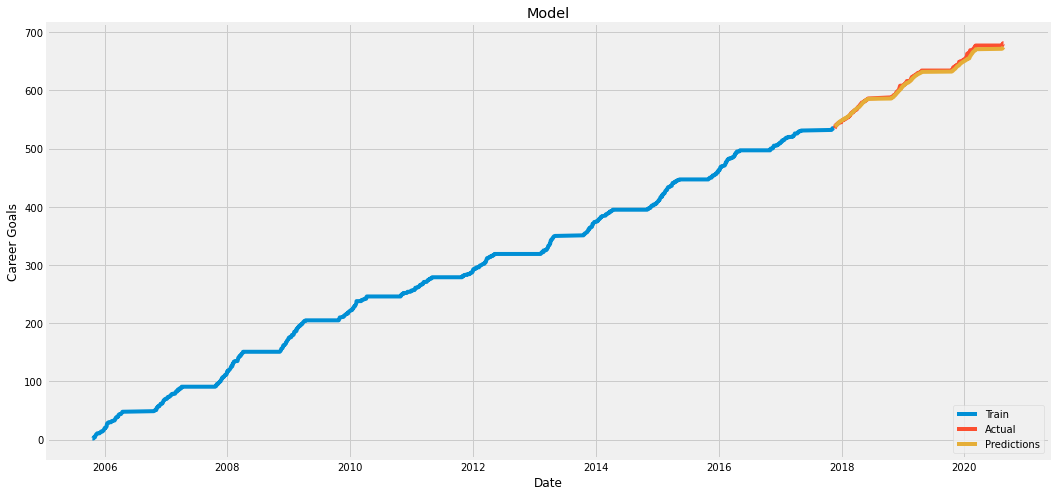

In [60]:
# Plot how our model performed versus the actual results
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Career Goals')
plt.plot(train['careerGoals'])
plt.plot(valid[['careerGoals', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.show()

## Neural Net Performance
Hopefully, we see from the above graphic that the model's predictions run close to the actual results from our training/test dataset. I noticed that I would get varying results every time I ran this. Sometimes the RMSE would be as high as 64, and other times it would be 0.2. I tried to include differences in the layers of my model, hyperparameter tuning, and adjusting using L1 and L2 weights, but other than narrowing the gap in these differences, I still wasn't able to get a consistent result. This would require more research and possibly more data or different parameters. Many neural networks training on thousands of records. The problem here with hockey players, most don't play more than 1000 games in their career. This could also be why the model is inconsistent, lack of data.

In [63]:
# Show the results
valid

,careerGoals,Predictions
date,,
2017-11-21,535,538.420593
2017-11-23,536,538.630920
2017-11-24,537,538.876831
2017-11-26,540,539.196655
2017-12-01,540,539.754700
...,...,...
2020-08-12,677,671.367065
2020-08-15,679,672.029114
2020-08-16,679,672.761047


## Just for Fun
I wanted to see how it could predict the next game's total career goals if there was another record.

In [64]:
# predict the next record's goals 
goal_count = oviData

new_df = goal_count.filter(['careerGoals'])

last_60_values = new_df[-60:].values

last_60_values_scaled = scaler.transform(last_60_values)

X_test = []

X_test.append(last_60_values_scaled)

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred_goals = model.predict(X_test)

pred_goals = scaler.inverse_transform(pred_goals)
print(pred_goals)

[[675.0253]]
